# Ablation studies

This notebook performs the analysis for a series of ablation studies using the DUD-E dataset.

The baseline model is the multi-run, multi-level (atom/surface) ensemble trained on PDBbind refined set. 

The ablation studies are the following:
* No multi-run ensembling (i.e., single-run prediction with atom/surface ensemble)
* No model pre-training
* No negative sampling
* Classification head instead of multi-output regression head

Finally, we perform an additional ablation study for the atom-/surface-level ensembling. In this case we only use the targets for which surface-level pre-processing is successful, i.e., 94/102 targets. Therefore, comparisons for this ablation study are perfromed separately.

In [1]:
import os 

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import ensembling
import filtering
import metrics
import parsing
import postprocessing

# 1. Configuration

In [2]:
# Results paths
MAIN_PATH = '/nfs-data/a.krasoulis/pharma/pdbbind/binding_affinity/paper_results/ablation'
MODELS = ['atom', 'surface']
DATASET = 'DUD-E'
AVG_FUN = np.median  # Average function for computing mirco-average scores
EF_ALPHA = 0.01 # alpha for EF metric (i.e., EF1)
BEDROC_ALPHA = 80.5 # alpha for BedROC metric (i.e, BedROC80.5)

PATH_RESULTS = {
    'baseline': {
        'atom': '../data/outputs/denvis_outputs/dude_main_refined_atom.parquet',
        'surface': '../data/outputs/denvis_outputs/dude_main_refined_surface.parquet'},
    'no_ensemble': {
        'atom': '../data/outputs/denvis_outputs/dude_main_refined_atom.parquet',
        'surface': '../data/outputs/denvis_outputs/dude_main_refined_surface.parquet'},
    'no_negatives': {
        'atom': '../data/outputs/denvis_outputs/dude_ablation_no_neg_sampling_atom.parquet',
        'surface': '../data/outputs/denvis_outputs/dude_ablation_no_neg_sampling_surface.parquet'},
    'no_pretraining': {
        'atom': '../data/outputs/denvis_outputs/dude_ablation_no_pretraining_atom.parquet',
        'surface': '../data/outputs/denvis_outputs/dude_ablation_no_pretraining_surface.parquet'},
    'binding_classification': {
        'atom': '../data/outputs/denvis_outputs/dude_ablation_classification_atom.parquet',
        'surface': '../data/outputs/denvis_outputs/dude_ablation_classification_surface.parquet'}
}

# Network output aggregation kwargs
# Refined models have two outpus (Ki, Kd)
# The classification output has a single output which gives the predicted binding probability
OUTPUT_COMBINATION_KWS = {
    'baseline': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.0, 'use_clf': False},
    'no_ensemble': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.0, 'use_clf': False},
    'no_negatives': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.0, 'use_clf': False},
    'no_pretraining': {'y_aff_weight': 0., 'y_kd_weight': 0.5, 'y_ki_weight': 0.5, 'y_ic50_weight': 0.0, 'use_clf': False},
    'binding_classification': {'y_aff_weight': 0., 'y_kd_weight': 0., 'y_ki_weight': 0., 'y_ic50_weight': 0.0, 'use_clf': True},
}

# 2. Parse results

## 2.1 Ablation studies (excluding atom/surface ensemble)

In [3]:
results = dict()
for model, paths in PATH_RESULTS.items():
    results_cache = dict()
    for protein_model, path in paths.items():
        results_tmp, _ = parsing.parse_results_denvis(path)
        if model == 'no_ensemble':
            results_cache[protein_model] = results_tmp[(results_tmp['version']==0) & (results_tmp['ckpt']==0)] # Best-performing ckpt / first run
            results_cache[protein_model] = results_cache[protein_model].drop(columns=['version', 'ckpt'])  # Discard version and ckpt columns
        else:
            results_cache[protein_model] = ensembling.compute_ensemble_scores(results_tmp, version=True)
    
    results_ens = ensembling.compute_level_ensemble_scores(results_cache['atom'], results_cache['surface'], atom_weight=0.5, use_target_intersection=False)
    results[model] = postprocessing.combine_outputs(results_ens, **OUTPUT_COMBINATION_KWS[model])

## 2.2 Atom-level / surface-level / atom-surface-level ensemble

In [4]:
# We compare to the baseline model so we use the output scores for
# the same model
model = 'baseline'
results_cache = dict()
for protein_model, path in PATH_RESULTS[model].items():
    results_tmp, _ = parsing.parse_results_denvis(path)
    results_cache[protein_model] = ensembling.compute_ensemble_scores(results_tmp, version=True)
    
filtering_list = []
for _, result in results_cache.items():
    filtering_list.append(list(result.target_id.unique()))
            
target_inter = filtering.target_intersection(filtering_list)
results['atom'] = filtering.filter_targets(results_cache['atom'], target_inter)
results['surface'] = filtering.filter_targets(results_cache['surface'], target_inter)

# Set use_target_intersection to True so that we compare across the same targets
results['ensemble'] = ensembling.compute_level_ensemble_scores(
        results['atom'], results['surface'], atom_weight=0.5, use_target_intersection=True)

# Output aggregation for the three models
for model in ['atom', 'surface', 'ensemble']:
    results[model] = postprocessing.combine_outputs(results[model], **OUTPUT_COMBINATION_KWS['baseline'])

# 3. Ablations

## 3.1 Compute performance scores

In [5]:
auroc_pt = dict()  # AUROC, per-target
auroc_micro = dict()  # AUROC, micro-average
pr_pt = dict()  # Precision-recall, per-target
pr_macro = dict()  # Precision-recall, macro-average
ef1_pt = dict()  # EF1, per-target
ef1_micro = dict()  # EF1, micro-average
bedroc805_pt = dict()  # EF1, per-target
bedroc805_micro = dict()  # EF1, micro-average

for model in results.keys():
    auroc_pt[model], auroc_micro[model] = metrics.compute_auroc_scores(results[model], avg_fun=AVG_FUN)
    ef1_pt[model], ef1_micro[model] = metrics.compute_ef_scores(results[model], alpha=EF_ALPHA, avg_fun=AVG_FUN)
    bedroc805_pt[model], bedroc805_micro[model] = metrics.compute_bedroc_scores(results[model], alpha=BEDROC_ALPHA, avg_fun=AVG_FUN)
    pr_pt[model], pr_macro[model] = metrics.compute_pr_scores(results[model])

# Tidy format
tf_df = pd.DataFrame(columns=['Model', 'Target', 'AUROC', 'EF1', 'BEDROC'])
tf_df_micro = pd.DataFrame(columns=['Model', 'AUROC', 'EF1', 'BEDROC'])
for model in results.keys():
    # Update micro DataFrame
    new_entry_micro = pd.DataFrame({
            'Model': [model],
            'AUROC': [auroc_micro[model]],
            'EF1': [ef1_micro[model]],
            'BEDROC': [bedroc805_micro[model]]})
    tf_df_micro = pd.concat((tf_df_micro, new_entry_micro), axis='index')
    
    # Update per-target dataframe
    for target in auroc_pt[model].keys():
        new_entry = pd.DataFrame({
            'Model': [model],
            'Target': [target],
            'AUROC': [auroc_pt[model][target]],
            'EF1': [ef1_pt[model][target]],
            'BEDROC': [bedroc805_pt[model][target]]})
        tf_df = pd.concat((tf_df, new_entry), axis='index')

## 3.2 Micro-average score comparison (Table 6)

In [6]:
pd.options.display.float_format = '{:.2f}'.format
print_order = ['baseline', 'no_ensemble', 'no_pretraining', 'no_negatives', 'binding_classification', 'ensemble', 'atom', 'surface']
cols = ['AUROC', 'EF1', 'BEDROC']
label_alias = {
    'baseline': 'Multi-ensemble (baseline)',
    'no_ensemble': 'Single model prediction',
    'no_pretraining': 'Without pre-training',
    'no_negatives': 'Without negative sampling',
    'binding_classification': 'Binding classification',
    'ensemble': 'Level ensemble',
    'atom': 'Atom-level',
    'surface': 'Surface-level'
}
print_df = tf_df_micro.set_index('Model').loc[print_order][cols].round(decimals=2).rename(index=label_alias)
print_df.index.name = None  # Remove index name
print_df

,AUROC,EF1,BEDROC
Multi-ensemble (baseline),0.87,17.05,0.35
Single model prediction,0.83,11.64,0.25
Without pre-training,0.86,17.87,0.33
Without negative sampling,0.65,3.14,0.07
Binding classification,0.77,10.00,0.20
Level ensemble,0.88,18.46,0.38
Atom-level,0.85,13.33,0.27
Surface-level,0.77,13.85,0.26


## 3.3 Statistical comparisons (Table 7)

In [7]:
pd.options.display.float_format = '{:.2e}'.format
perf_metrics = ['AUROC', 'EF1', 'BEDROC']

def statistical_notation(p_val):
    if p_val < 1e-3:
        res = '***'
    elif p_val < 1e-2:
        res = '**'
    elif p_val < 0.05:
        res = '*'
    else:
        res = 'n.s.'
    
    return res

comparisons = [
    ('baseline', 'no_ensemble'),
    ('baseline', 'no_pretraining'),
    ('baseline', 'no_negatives'),
    ('baseline', 'binding_classification'),
    ('ensemble', 'atom'),
    ('ensemble', 'surface')
]

label_alias = {
    'baseline': 'Multi-ensemble (baseline)',
    'no_ensemble': 'Single model prediction',
    'no_pretraining': 'Without pre-training',
    'no_negatives': 'Without negative sampling',
    'binding_classification': 'Binding classification',
    'ensemble': 'Level ensemble',
    'atom': 'Atom-level',
    'surface': 'Surface-level'
}

df_comparison = pd.DataFrame(columns=['Model 1', 'Model 2'] + perf_metrics)
df_comparison['Model 1'] = [model[0] for model in comparisons]
df_comparison['Model 2'] = [model[1] for model in comparisons]

multcompare_method = 'sidak'
for perf_metric in perf_metrics:    
    p_val_uncorr = []
    n_comparisons = len(comparisons)
    for comparison in comparisons:
        model_x, model_y = comparison
        x = tf_df[tf_df['Model']==model_x].set_index('Target').sort_index()[perf_metric].values
        y = tf_df[tf_df['Model']==model_y].set_index('Target').sort_index()[perf_metric].values
        p_val_uncorr.append(pg.wilcoxon(x=x, y=y, alternative='two-sided')['p-val']['Wilcoxon'])

    # Perform multiple comparisons
    nh_reject, p_val_corr = pg.multicomp(pvals=p_val_uncorr, alpha=0.05, method=multcompare_method)
    df_comparison[perf_metric] = p_val_corr

for perf_metric in perf_metrics:
    df_comparison[perf_metric] = df_comparison.apply(lambda row: statistical_notation(row[perf_metric]), axis=1)


print_df = df_comparison.replace(to_replace=label_alias).set_index(['Model 1', 'Model 2'])
print_df.index.names = None, None
print_df

AUROC   EF1 BEDROC
Multi-ensemble (baseline) Single model prediction     ***   ***    ***
                          Without pre-training       n.s.  n.s.   n.s.
                          Without negative sampling   ***   ***    ***
                          Binding classification      ***   ***    ***
Level ensemble            Atom-level                    *   ***    ***
                          Surface-level               ***   ***    ***

## 3.4 Per-target comparison (Figure 5)

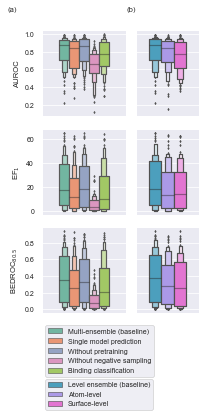

In [8]:
# Make a copy with a dummy column to use as x so that Model is used as hue
# This is done to turn x-axis labels to a legend (there might actually be a more elegant way of doing that)
tf_df_dummy = tf_df.copy(deep=True)
tf_df_dummy['dummy'] = ''

showfliers = True
fliersize = 1
linewidth = 1.2
width = 0.6
strip_size = 1.
figsize = (2.8,5.2)

leg_loc_abl = (-0.01, -2.4)
leg_loc_ens = (-0.01, -1.88)

sns.set_context("paper", font_scale=.8, rc={"lines.linewidth": 1.5})
perf_metrics = ['AUROC', 'EF1', 'BEDROC']
hue_orders = {
    'ablation': ['baseline', 'no_ensemble', 'no_pretraining', 'no_negatives', 'binding_classification'],
    'ensemble': ['ensemble', 'atom', 'surface']}
color_palettes = {
    'ablation': sns.color_palette('Set2', n_colors=len(hue_orders['ablation'])),
    'ensemble': sns.color_palette('husl', n_colors=len(hue_orders['ablation']) + len(hue_orders['ensemble']))[len(hue_orders['ablation']):]}
label_names = {
    'ablation': {
        'baseline': 'Μulti-ensemble (baseline)',
        'no_ensemble': 'Single model prediction',
        'no_pretraining': 'Without pretraining',
        'no_negatives': 'Without negative sampling',
        'binding_classification': 'Binding classification',
        'pdb_original': 'Custom pre-processing'},
    'ensemble': {
        'atom': 'Atom-level',
        'surface': 'Surface-level',
        'ensemble': 'Level ensemble (baseline)'}}

fig, ax = plt.subplots(figsize=figsize, nrows=3, ncols=2, sharey='row', gridspec_kw={'width_ratios': (4.0/7.0, 3.0/7.0)})
for (i, metric) in enumerate(perf_metrics):
    for (j, comp_type) in enumerate(hue_orders):
        sns.boxenplot(
            data=tf_df_dummy,
            x='dummy',
            y=metric,
            hue='Model',
            hue_order=hue_orders[comp_type],
            palette=color_palettes[comp_type],
            showfliers=showfliers,
            width=width,
            linewidth=linewidth,
            ax=ax[i, j])
        
        # Formatting
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        ax[i, j].set_xticklabels([])
        # Temporary workaround for setting fliersize for boxenplot
        # see: https://github.com/mwaskom/seaborn/issues/2701
        plt.setp(ax[i, j].collections[::2], sizes=[2 ** fliersize])
        

# Tidy-up
handles_l, labels_l = ax[0,0].get_legend_handles_labels()
handles_r, labels_r = ax[0,1].get_legend_handles_labels()
handles_new = handles_l[:len(hue_orders['ablation'])] + handles_r[:len(hue_orders['ensemble'])]
labels_new = [label_names['ablation'][label] for label in labels_l[:len(hue_orders['ablation'])]] + [label_names['ensemble'][label] for label in labels_r[:len(hue_orders['ensemble'])]]
ax[0,0].legend(handles=handles_l, labels=[label_names['ablation'][label] for label in labels_l[:len(hue_orders['ablation'])]], bbox_to_anchor=leg_loc_abl, loc='upper left')
ax[1,0].legend(handles=handles_r, labels=[label_names['ensemble'][label] for label in labels_r[:len(hue_orders['ensemble'])]], bbox_to_anchor=leg_loc_ens, loc='upper left')
ax[1,1].legend().remove()
ax[0, 1].legend().remove()
ax[2, 0].legend().remove()
ax[2, 1].legend().remove()

ax[0,0].set_ylabel('AUROC')
ax[1,0].set_ylabel(r'EF$_{1}$')
ax[2,0].set_ylabel(r'BEDROC$_{80.5}$')

fig.text(-0.05, 0.93, '(a)')
fig.text(4/7-0.03, 0.93, '(b)')
plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.show()

## 3.5 Atom/surface-level ensemble precision-recall curves (Figure 6)

EF1: atom, 29.43; surface, 15.96; ensemble, 36.17


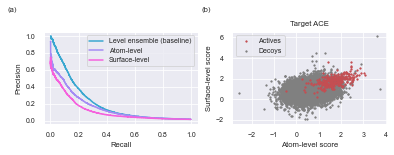

In [9]:
sns.set_context("paper", font_scale=.8, rc={"lines.linewidth": 1.5})

target = 'ace'
pre_rec_cutoff = -15
output_metric = 'y_score'

figsize = (5.4,2.)
scatter_size = 2
pos_color = 'r'
neg_color = 'gray'
color_palettte_ens = sns.color_palette('husl', n_colors=len(hue_orders['ablation']) + len(hue_orders['ensemble']))[len(hue_orders['ablation']):]
label_name_ens = {'atom': 'Atom-level', 'surface': 'Surface-level', 'ensemble': 'Level ensemble (baseline)'}

atom_scores_pos = results['atom'][(results['atom']['target_id']==target) & (results['atom']['y_true']==1)].sort_values(by='ligand_id')[output_metric].values
surface_scores_pos = results['surface'][(results['surface']['target_id']==target) & (results['surface']['y_true']==1)].sort_values(by='ligand_id')[output_metric].values
atom_scores_neg = results['atom'][(results['atom']['target_id']==target) & (results['atom']['y_true']==0)].sort_values(by='ligand_id')[output_metric].values
surface_scores_neg = results['surface'][(results['surface']['target_id']==target) & (results['surface']['y_true']==0)].sort_values(by='ligand_id')[output_metric].values

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(121)
for model, color in zip(['ensemble', 'atom', 'surface'], color_palettte_ens):
    ax.plot(pr_macro[model][1][:pre_rec_cutoff], pr_macro[model][0][:pre_rec_cutoff], label=model, c=color, drawstyle='steps-post')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[label_name_ens[label] for label in labels], loc='upper right')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

ax = fig.add_subplot(122)
ax.scatter(atom_scores_neg, surface_scores_neg, c=neg_color, s=scatter_size, label='Decoys')
ax.scatter(atom_scores_pos, surface_scores_pos, c=pos_color, s=scatter_size, label='Actives')
ax.set_xlabel('Atom-level score')
ax.set_ylabel('Surface-level score')
ax.set_title(f'Target {target.upper()}')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1], labels=labels[::-1], loc='upper left') # Actives on top

fig.text(0, 1.0, '(a)')
fig.text(0.5, 1.0, '(b)')
fig.tight_layout()
print('EF1: atom, {:.2f}; surface, {:.2f}; ensemble, {:.2f}'.format(ef1_pt['atom'][target], ef1_pt['surface'][target], ef1_pt['ensemble'][target]))
plt.show()